## Lab 2: Базові алгоритми навчання без учителя та обробка текстових даних (Scikit-learn lib)

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [31]:
df = pd.read_csv('spotify_churn_dataset.csv')

print('Розмір датасету: ', df.shape[0], ' записів та ', df.shape[1], ' параметрів')
print('Назви колонок ( параметрів ): ', ", ".join(df.columns))

print('\nПерші 5 записів:')
df.head()

Розмір датасету:  8000  записів та  12  параметрів
Назви колонок ( параметрів ):  user_id, gender, age, country, subscription_type, listening_time, songs_played_per_day, skip_rate, device_type, ads_listened_per_week, offline_listening, is_churned

Перші 5 записів:


,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


In [37]:
# видаляємо параметр, який слугує ідентифікатором
df.drop("user_id", axis=1, inplace=True)

num_features = ["age", "listening_time", "songs_played_per_day", "ads_listened_per_week"]
print("Data describe:")
cm = sns.light_palette("blue", as_cmap=True)
display(df[num_features].describe().T.style.background_gradient(cmap=cm))

# перевірка на дублікати
def check_duplicates_report(df, dataset_name):
    duplicates_count = df.duplicated().sum()
    total_rows = len(df)
    
    print(f"🔍 {dataset_name} Аналіз дублікатів")
    
    if duplicates_count == 0:
        print(f"✅ Дублікатів не знайдемо серед {total_rows:,} записів")
    else:
        print(f"⚠️  {duplicates_count} duplicates found ({duplicates_count/total_rows:.2%})")
        print(f"    Total rows affected: {duplicates_count:,}/{total_rows:,}")

datasets = {
    "Data": df
}

duplicate_summary = {}
for name, data in datasets.items():
    check_duplicates_report(data, name)
    duplicate_summary[name] = {
        "duplicates": data.duplicated().sum(),
        "total_rows": len(data)
    }
    
# 1. One-Hot Encoding для gender, subscription_type, device_type
one_hot_cols = ['gender', 'subscription_type', 'device_type']
df_one_hot = pd.get_dummies(df[one_hot_cols], drop_first=True)

# 2. Frequency Encoding для country
freq_encoding = df['country'].value_counts(normalize=True)  # частка появи
df['country_freq'] = df['country'].map(freq_encoding)

df_encoded = pd.concat([df.drop(columns=one_hot_cols + ['country']), df_one_hot], axis=1)

# Тепер df_encoded
print("Після кодування:")
df_encoded.head()

# Створюємо копію df_encoded, щоб не зіпсувати оригінал
df = df_encoded.copy()

# 1. Standard Scaling для age та songs_played_per_day
scaler_std = StandardScaler()
df[['age_scaled', 'songs_played_scaled']] = scaler_std.fit_transform(df[['age', 'songs_played_per_day']])
df.drop(columns=['age', 'songs_played_per_day'], inplace=True)  # видаляємо оригінальну колонку

# 2. MinMax Scaling для listening_time
scaler_mm = MinMaxScaler()
df['listening_time_scaled'] = scaler_mm.fit_transform(df[['listening_time']])
df.drop(columns=['listening_time'], inplace=True)  # видаляємо оригінальну колонку

# 3. Log + MinMax для ads_listened_per_week
df['ads_log_scaled'] = np.log1p(df['ads_listened_per_week'])
df['ads_scaled'] = scaler_mm.fit_transform(df[['ads_log_scaled']])
df.drop(columns=['ads_listened_per_week', 'ads_log_scaled'], inplace=True)

df.head()

Data describe:


,count,mean,std,min,25%,50%,75%,max
age,8000.000000,37.662125,12.740359,16.000000,26.000000,38.000000,49.000000,59.000000
listening_time,8000.000000,154.068250,84.015596,10.000000,81.000000,154.000000,227.000000,299.000000
songs_played_per_day,8000.000000,50.127250,28.449762,1.000000,25.000000,50.000000,75.000000,99.000000
ads_listened_per_week,8000.000000,6.943875,13.617953,0.000000,0.000000,0.000000,5.000000,49.000000


🔍 Data Аналіз дублікатів
✅ Дублікатів не знайдемо серед 8,000 записів
Після кодування:


,skip_rate,offline_listening,is_churned,country_freq,gender_Male,gender_Other,subscription_type_Free,subscription_type_Premium,subscription_type_Student,device_type_Mobile,device_type_Web,age_scaled,songs_played_scaled,listening_time_scaled,ads_scaled
0,0.20,0,1,0.119250,False,False,True,False,False,False,False,1.282452,-0.953574,0.055363,0.885919
1,0.34,1,0,0.126875,False,True,False,False,False,False,True,-0.365956,0.417349,0.453287,0.000000
2,0.04,1,1,0.129250,True,False,False,True,False,True,False,0.026522,-0.426296,0.653979,0.000000
3,0.31,1,0,0.119250,False,False,False,False,True,True,False,-1.229408,-1.691763,0.089965,0.000000
4,0.36,1,1,0.129000,False,True,False,False,False,True,False,-0.679939,0.241590,0.830450,0.000000


1. Зниження
розмірності і візуалізація даних

Візьміть датасет, з яким ви працювали в лабораторній №1, застосуйте sklearn.decomposition.PCA  для зниження
розмірності, на отриманих даних запустіть один із алгоритмів з Lab 1, порівняйте результати: якість класифікації на початкових даних та якість після зменшення розмірності. Зробіть висновки: як вплинуло зменшення розмірності на алгоритм? Чи
пришвидшилось навчання, чи знизилась точність?
Для того ж датасету, застосуйте sklearn.manifold.TSNE для зниження розмірності до 2D. Поясніть результат
Приклади: https://github.com/natsakh/IAD/tree/main/Pr_3

========== РЕЗУЛЬТАТИ БЕЗ PCA ==========
Accuracy: 0.745625
Час навчання: 0.8038341999053955
              precision    recall  f1-score   support

           0       0.75      0.99      0.85      1200
           1       0.33      0.02      0.03       400

    accuracy                           0.75      1600
   macro avg       0.54      0.50      0.44      1600
weighted avg       0.65      0.75      0.65      1600


========== РЕЗУЛЬТАТИ З PCA ==========
Accuracy: 0.73875
Час навчання: 4.279565095901489
              precision    recall  f1-score   support

           0       0.75      0.98      0.85      1200
           1       0.28      0.03      0.05       400

    accuracy                           0.74      1600
   macro avg       0.51      0.50      0.45      1600
weighted avg       0.63      0.74      0.65      1600



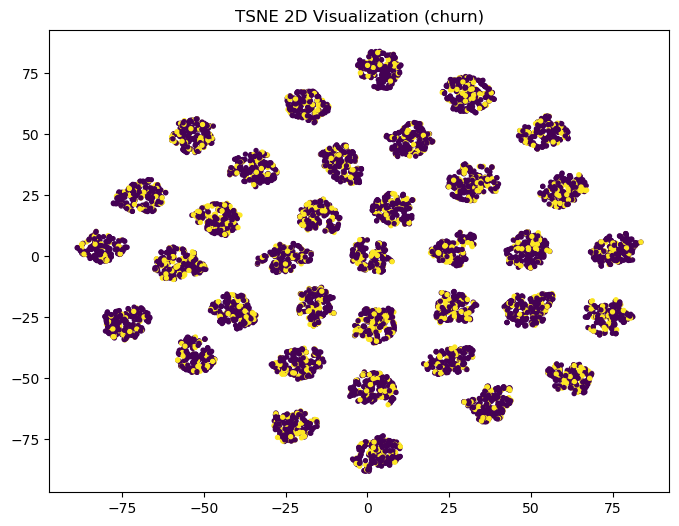

In [41]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# 2. Цільова колонка (якщо називається інакше — замініть)
target_col = "is_churned"

# 3. X та y
X = df.drop(columns=[target_col])
y = df[target_col]

# 4. Масштабування
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------------------------
# 5. КЛАСИФІКАЦІЯ БЕЗ PCA (оригінальні дані)
# ------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)

start = time.time()
clf.fit(X_train, y_train)
train_time_orig = time.time() - start

y_pred = clf.predict(X_test)

print("========== РЕЗУЛЬТАТИ БЕЗ PCA ==========")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Час навчання:", train_time_orig)
print(classification_report(y_test, y_pred))

# ------------------------------------------------
# 6. КЛАСИФІКАЦІЯ З PCA
# ------------------------------------------------
pca = PCA(n_components=10)  # зменшуємо розмірність наприклад до 10
X_pca = pca.fit_transform(X_scaled)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

clf_pca = RandomForestClassifier(random_state=42)

start = time.time()
clf_pca.fit(X_train_pca, y_train_pca)
train_time_pca = time.time() - start

y_pred_pca = clf_pca.predict(X_test_pca)

print("\n========== РЕЗУЛЬТАТИ З PCA ==========")
print("Accuracy:", accuracy_score(y_test_pca, y_pred_pca))
print("Час навчання:", train_time_pca)
print(classification_report(y_test_pca, y_pred_pca))

# ------------------------------------------------
# 7. TSNE до 2D (візуалізація)
# ------------------------------------------------
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=8)
plt.title("TSNE 2D Visualization (churn)")
plt.show()

2. Кластерний аналіз
Візьміть будь-яке зображення. За допомогою алгоритму k-means зробіть квантування зображення (зменшення
кількості різних кольорів у зображенні) з глибиною 64, 32, 16 та 8 рівнів для будь-якого обраного самостійно зображення. Порівняйте отримані зображення.
Приклади: https://github.com/natsakh/IAD/tree/main/Pr_3

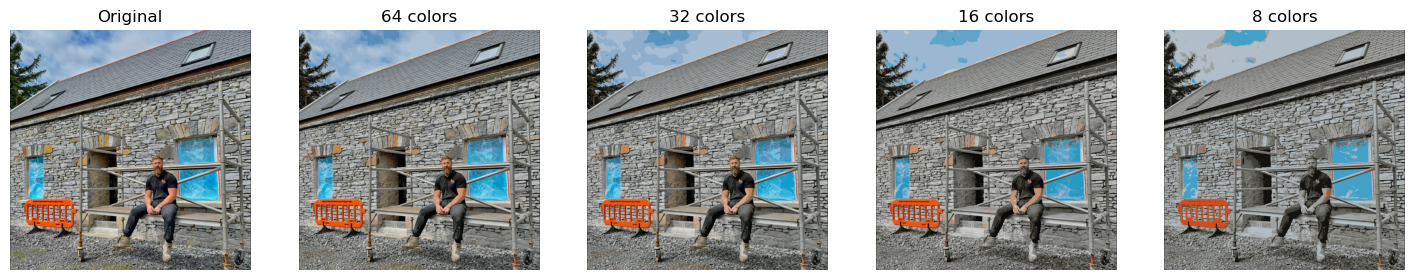

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image

# 1. Завантажуємо зображення
# Можна замінити 'sample.jpg' на будь-який шлях до вашого файлу
img = Image.open("Sample.jpg")
img_np = np.array(img)

# 2. Перетворюємо у 2D масив пікселів
pixels = img_np.reshape(-1, 3)

# Функція для квантування k-means
def quantize_kmeans(pixels, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pixels)
    new_colors = kmeans.cluster_centers_.astype("uint8")
    new_img = new_colors[labels]
    return new_img.reshape(img_np.shape)

# 3. Квантування з різною кількістю кольорів
img_64  = quantize_kmeans(pixels, 64)
img_32  = quantize_kmeans(pixels, 32)
img_16  = quantize_kmeans(pixels, 16)
img_8   = quantize_kmeans(pixels, 8)

# 4. Відображення
fig, axes = plt.subplots(1, 5, figsize=(18, 6))
axes[0].imshow(img_np)
axes[0].set_title("Original")
axes[1].imshow(img_64)
axes[1].set_title("64 colors")
axes[2].imshow(img_32)
axes[2].set_title("32 colors")
axes[3].imshow(img_16)
axes[3].set_title("16 colors")
axes[4].imshow(img_8)
axes[4].set_title("8 colors")

for ax in axes:
    ax.axis('off')

plt.show()

3. Обробка та класифікація текстових даних
Завантажте набір текстових даних (з мітками класів). Проведіть передобробку даних (видаліть стоп-слова, пунктуацію),
за допомогою wordcloud зробіть візуалізацію найбільш поширених слів або n-gram у кожному класі. Векторизуйте тексти
(наприклад за допомогою sklearn.feature_extraction.text.TfidfVectorizer).
Проведіть класифікацію текстових даних, зробіть оцінку якості. 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bohdanr/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


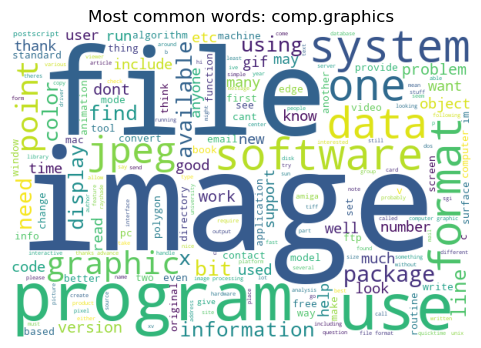

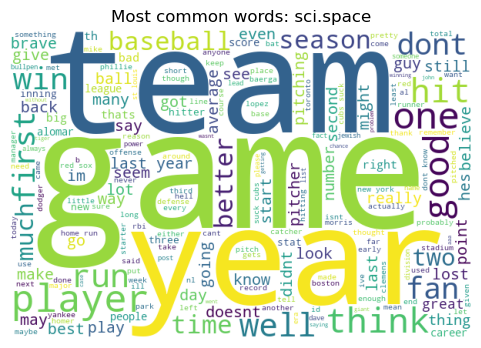

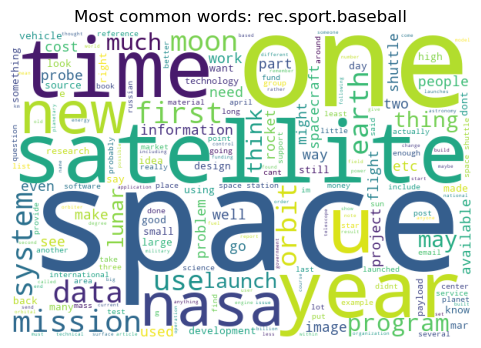

Accuracy: 0.8901408450704226

Classification Report:

                    precision    recall  f1-score   support

     comp.graphics       0.91      0.88      0.89       119
rec.sport.baseball       0.94      0.86      0.90       117
         sci.space       0.83      0.92      0.88       119

          accuracy                           0.89       355
         macro avg       0.89      0.89      0.89       355
      weighted avg       0.89      0.89      0.89       355



In [49]:
# === 1. Завантажуємо датасет ===
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# скачати стоп-слова
nltk.download('stopwords')

# вибираємо декілька категорій (для прикладу)
cats = ['comp.graphics', 'sci.space', 'rec.sport.baseball']
data = fetch_20newsgroups(subset='train', categories=cats, remove=('headers','footers','quotes'))

texts = data.data
labels = data.target
label_names = data.target_names

# === 2. Передобробка тексту ===
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # видаляємо пунктуацію та цифри
    text = " ".join([w for w in text.split() if w not in stop_words])
    return text

texts_clean = [preprocess(t) for t in texts]

# === 3. WordCloud для кожного класу ===
for idx, category in enumerate(cats):
    class_text = " ".join([texts_clean[i] for i in range(len(labels)) if labels[i] == idx])
    wc = WordCloud(width=600, height=400, background_color='white').generate(class_text)
    plt.figure(figsize=(6,4))
    plt.imshow(wc)
    plt.title(f"Most common words: {category}")
    plt.axis('off')
    plt.show()

# === 4. Векторизація TF-IDF ===
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(texts_clean)
y = labels

# === 5. Розбиття та навчання класифікатора ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

# === 6. Оцінка якості ===
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_names))